# Part A: Filtering gauges and creating groups

## Introduction
This notebook contains _all code_ that has been used to filter, preprocess and create the _seven_ calibration-validation groups for the modelling performed for the paper "Can more detailed geological maps improve streamflow prediction in ungauged basins?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

## Requirements

**Files**

- estreams_gauging_stations.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 11 February 2025)
- estreams_geology_moselle_regional_attributes.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 15 February 2025)
- estreams_attributes_filtered_quality_geology_v01.csv https://github.com/thiagovmdon/LSH-quality_geology (Last access: 11 February 2025)



## Import modules

In [ ]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from utils.functions import find_max_unique_rows
import tqdm as tqdm
import random
import seaborn as sns
import geopandas as gpd

## Configurations

In [2]:
# Path to where the EStreams dataset is stored
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

## Import data

In [40]:
# Read the gauges network metadata (from EStreams):
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Attributes already filtered from EStreams previously in do Nascimento et al. (2025a):
estreams_attributes = pd.read_csv('../data/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')
estreams_attributes.set_index("basin_id", inplace = True)

# Geological attributes (regional scale). Same ones provided in do Nascimento et al. (2025a):
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

## Preprocessing

### Network data organization

In [5]:
# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

### Geological data organization

In [6]:
geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

### Further filter of the network

In [8]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

100%|██████████| 1/1 [00:00<00:00, 332.59it/s]


### Check for potential outliers/problems

In [9]:
# Plot the hydrographs to filter out potential outliers
# Create a folder to save the plots
output_dir = r"..\results\plots\moselle"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    csv_file = fr"C:\Users\nascimth\Documents\data\EStreams\data\estreams_timeseries_{basin_id}.csv"
    
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 112/112 [00:15<00:00,  7.11it/s]


In [10]:
# Make a Gannt plot for the gauges time-series
data_folder = r"C:\Users\nascimth\Documents\data\EStreams\data"
gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))

gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

100%|██████████| 112/112 [00:04<00:00, 22.96it/s]


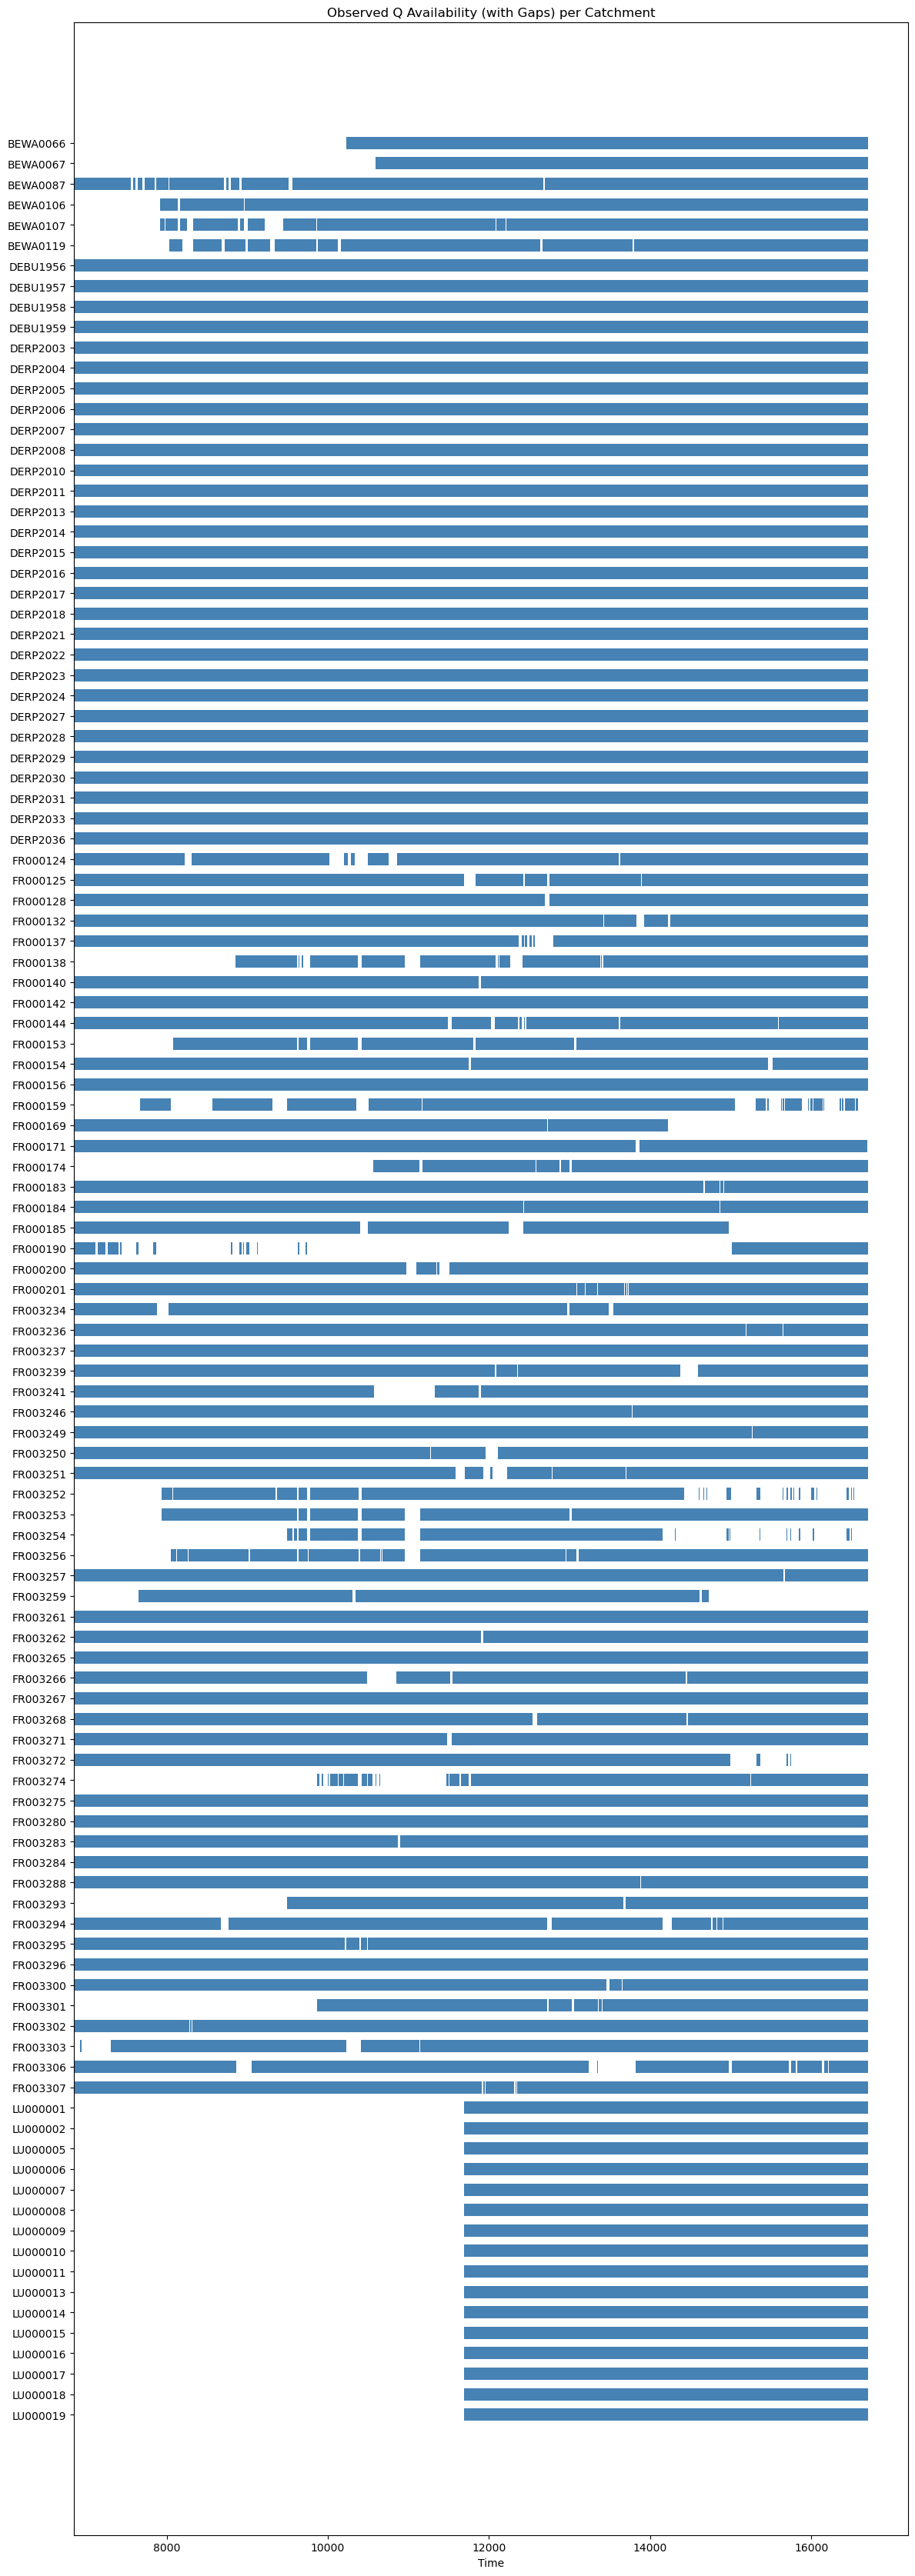

In [11]:
# Plot the Gannt graph
# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()

In [13]:
# Check for gauges with very low runoff ratio:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
BEWA0087    0.078
FR000174    0.271
FR003259    0.295
FR003266    0.253
Name: q_runoff_ratio, dtype: float64

Gauges with problems to be deleted:

- Too short time-series: FR000190
- Runoff ratio too small: BEWA0087
- Strange time-series: FR003303, FR003306 

In [14]:
# List of indexes to remove
to_remove = ['FR000190', 'BEWA0087', 'FR003303', 'FR003306']

# Drop them from the DataFrame
estreams_attributes_filtered = estreams_attributes_clipped_filters.drop(index=to_remove)

estreams_attributes_filtered

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
BEWA0119,63300000,Ouren,BE,BE_SPW,Our,6.141814,50.141935,6.141814,50.141935,NaN,...,7.381,1.400,3.429,17.0,3.0,3.0,94.0,75.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


## Division in 7 groups

### Sorting te areas

In [41]:
# First we sort the data based on their area:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_filtered.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]].head()

,area_estreams
basin_id,
DERP2028,50.000
DERP2006,54.000
BEWA0106,58.549
DERP2027,63.000
FR003234,64.468


### Dividing the groups

In [17]:
# Set your number of groups
n_groups = 7

# Input DataFrame
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

# Split LU and non-LU
df_lu = df_sorted[df_sorted['basin_id'].str.contains("LU")].copy()
df_nonlu = df_sorted[~df_sorted['basin_id'].str.contains("LU")].copy()

n_lu = len(df_lu)
print(f"Total LU gauges: {n_lu}")

# Shuffle LU gauges
df_lu = df_lu.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 1: Determine LU assignment per group
base_lu_per_group = n_lu // n_groups
extra_lu = n_lu % n_groups  # remainder to spread

# Create LU assignment list
lu_counts = [base_lu_per_group] * n_groups
for i in range(extra_lu):
    lu_counts[i] += 1  # Distribute extra LU gauges to first few groups

# Step 2: Assign LU gauges
grouped_gauges = {}
lu_index = 0
for i in range(n_groups):
    group_name = f'Group_{i+1}'
    n_lu_this_group = lu_counts[i]
    grouped_gauges[group_name] = df_lu.iloc[lu_index:lu_index + n_lu_this_group].to_dict('records')
    lu_index += n_lu_this_group

# Step 3: Assign non-LU gauges fairly and with area balance
df_nonlu_sorted = df_nonlu.sort_values(by='area_estreams').reset_index(drop=True)
total_nonlu = len(df_nonlu_sorted)

# Determine how many total gauges each group should get
total_gauges = len(df_sorted)
gauges_per_group = total_gauges // n_groups
extras = total_gauges % n_groups

# Track how many more non-LU gauges each group needs
remaining_slots = {}
for i in range(n_groups):
    group = f'Group_{i+1}'
    target_size = gauges_per_group + (1 if i < extras else 0)
    current_size = len(grouped_gauges[group])
    remaining_slots[group] = target_size - current_size

# Step 4: Stratify and assign non-LU gauges
n_slots = sum(remaining_slots.values())
strata = np.array_split(df_nonlu_sorted, n_slots)
np.random.seed(42)
group_cycle = list(remaining_slots.keys()) * 20
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    # Find a group that still has space
    while remaining_slots[group_cycle[group_idx]] == 0:
        group_idx += 1
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    remaining_slots[group] -= 1
    group_idx += 1

# Final groups
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final check
print(f"\nTotal gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# LU per group
for k, g in groups_df.items():
    n_lu = g['basin_id'].str.contains("LU").sum()
    print(f"{k}: {len(g)} gauges | LU: {n_lu} | Mean area: {g['area_estreams'].mean():.1f}")


Total LU gauges: 16

Total gauges assigned: 108 (should be 108)
Unique basin_ids: 108 (should be 108)
Any duplicates? False
Group_1: 16 gauges | LU: 3 | Mean area: 566.2
Group_2: 16 gauges | LU: 3 | Mean area: 1014.5
Group_3: 16 gauges | LU: 2 | Mean area: 2561.5
Group_4: 15 gauges | LU: 2 | Mean area: 1375.3
Group_5: 15 gauges | LU: 2 | Mean area: 1238.3
Group_6: 15 gauges | LU: 2 | Mean area: 1365.3
Group_7: 15 gauges | LU: 2 | Mean area: 2174.5


### Refining the groups

In [18]:
# Make sure to have at least one of each in our groups
estreams_attributes_clipped_sorted[estreams_attributes_clipped_sorted.perm_high_regi > 90.].index.tolist()

['FR000184', 'FR000144', 'DERP2013']

In [20]:
# Your required gauges
must_include = ['FR000184', 'FR000144', 'DERP2013']

# Make sure all must_include gauges exist in the full dataset
reference_df = pd.concat(groups_df.values()).drop_duplicates(subset="basin_id")

# Enforce presence in each group
for key, group_df in groups_df.items():
    # Check if group already has one of them
    if not any(basin in group_df["basin_id"].values for basin in must_include):
        # Pick a random gauge to inject
        chosen = random.choice(must_include)
        row = reference_df[reference_df["basin_id"] == chosen]
        if not row.empty:
            # Append the row to the group
            groups_df[key] = pd.concat([group_df, row], ignore_index=True)

In [21]:
groups_df["Group_1"][["basin_id", "area_estreams", 'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi']].sort_values("area_estreams")

,basin_id,area_estreams,perm_high_regi,perm_medium_regi,perm_low_regi
3,DERP2028,50.000,80.0,7.0,13.0
4,FR000183,70.750,66.0,29.0,5.0
0,LU000018,83.614,39.0,61.0,0.0
5,DERP2008,101.000,3.0,3.0,94.0
6,FR000137,114.081,9.0,91.0,0.0
16,FR000144,117.784,92.0,0.0,8.0
7,FR003294,147.470,1.0,99.0,0.0
1,LU000010,163.669,42.0,58.0,0.0
8,FR000185,188.492,75.0,23.0,2.0
9,FR000154,289.484,4.0,96.0,0.0


<Axes: >

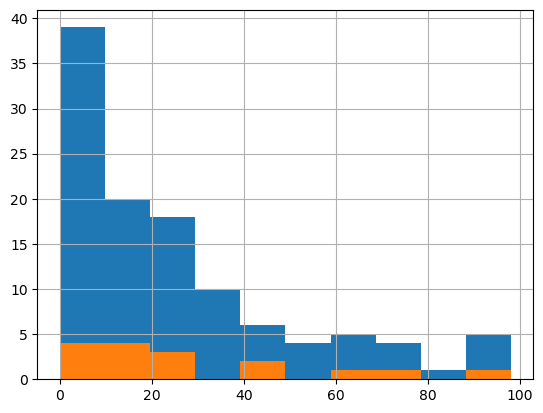

In [22]:
list_cal = groups_df["Group_7"][["basin_id", "area_estreams"]].basin_id.tolist()
estreams_attributes_clipped_filters.loc[list_cal, ["area_estreams",'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_high_glob2',
       'perm_medium_glob2', 'perm_low_glob2']].sort_values("area_estreams")


estreams_attributes_clipped_filters.perm_high_regi.hist()
estreams_attributes_clipped_filters.loc[list_cal, ["area_estreams",'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_high_glob2',
       'perm_medium_glob2', 'perm_low_glob2']].sort_values("area_estreams").perm_high_regi.hist()

In [23]:
# Final check
all_combined = pd.concat(groups_df.values())

print(f"\nTotal gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# LU per group
for k, g in groups_df.items():
    n_lu = g['basin_id'].str.contains("LU").sum()
    print(f"{k}: {len(g)} gauges | LU: {n_lu} | Mean area: {g['area_estreams'].mean():.1f}")



Total gauges assigned: 112 (should be 108)
Unique basin_ids: 108 (should be 108)
Any duplicates? True
Group_1: 17 gauges | LU: 3 | Mean area: 539.8
Group_2: 16 gauges | LU: 3 | Mean area: 1014.5
Group_3: 17 gauges | LU: 2 | Mean area: 2442.0
Group_4: 16 gauges | LU: 2 | Mean area: 1296.7
Group_5: 15 gauges | LU: 2 | Mean area: 1238.3
Group_6: 15 gauges | LU: 2 | Mean area: 1365.3
Group_7: 16 gauges | LU: 2 | Mean area: 2044.3


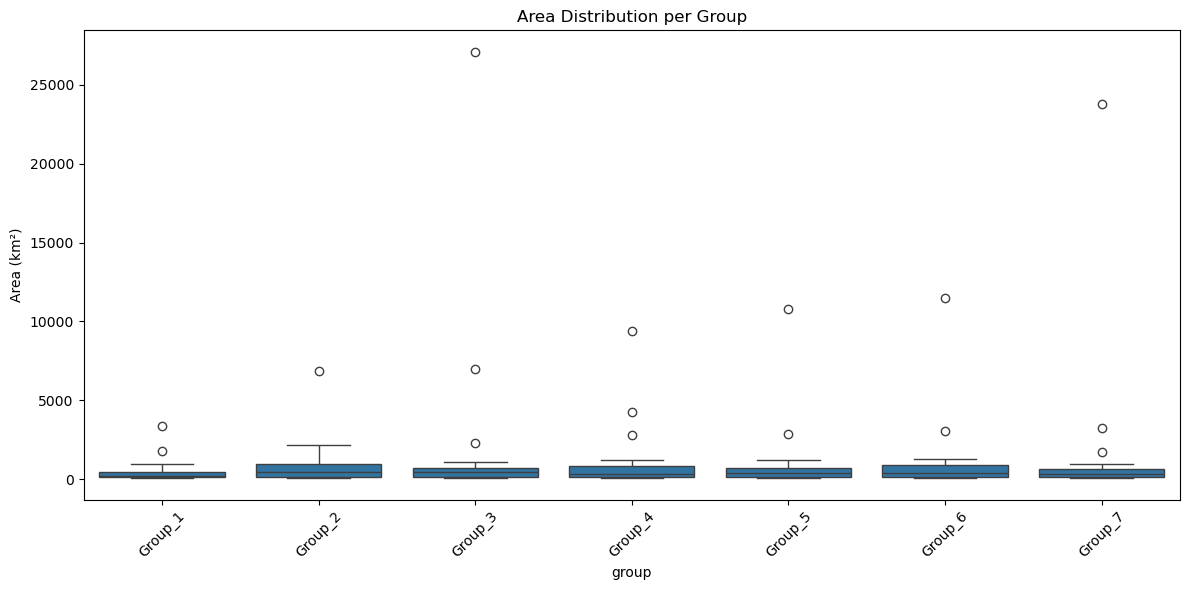

In [ ]:
combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# Combine all groups into one DataFrame
combined_df = pd.concat(
    [df.assign(group=group_name) for group_name, df in groups_df.items()],
    ignore_index=True
)

len(combined_df.basin_id.unique())

108

In [ ]:
GROUP = "Group_3"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
list_cal

['LU000008',
 'LU000005',
 'BEWA0106',
 'FR003280',
 'DERP2017',
 'DERP2031',
 'FR000125',
 'DERP2018',
 'DERP2022',
 'DERP2033',
 'FR003261',
 'FR003295',
 'FR003253',
 'FR003262',
 'DEBU1957',
 'DEBU1959',
 'DERP2013']

In [43]:
# Create a new dict with integer keys
groups_df = {i: v for i, (k, v) in enumerate(groups_df.items())}

groups_df[0]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,basin_id
0,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,NaN,...,0.015,0.015,17.0,39.0,61.0,0.0,0.0,100.0,0.0,LU000018
1,6,Hunnebuer,LU,LU_CONTACTFORM,Eisch,6.079524,49.729184,6.079524,49.729184,NaN,...,0.026,0.026,16.0,42.0,58.0,0.0,1.0,99.0,0.0,LU000010
2,17,Bigonville,LU,LU_CONTACTFORM,Sure,5.801399,49.869821,5.801399,49.869821,NaN,...,0.000,0.000,9.0,1.0,0.0,99.0,100.0,0.0,0.0,LU000001
3,2674030900,Eisenschmitt,DE,DE_RP,Salm,6.718000,50.048000,6.718000,50.048000,NaN,...,0.000,0.000,10.0,80.0,7.0,13.0,79.0,20.0,1.0,DERP2028
4,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,0.000,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0,FR000183
5,2628065000,Sinspelt,DE,DE_RP,Enz,6.323000,49.970000,6.323000,49.970000,NaN,...,0.000,0.574,8.0,3.0,3.0,94.0,1.0,99.0,0.0,DERP2008
6,A524201001,A5242010,FR,FR_EAUFRANCE,La Gitte à Velotte-et-Tatignécourt,6.174695,48.259608,6.174695,48.259608,273,...,0.024,0.019,2.0,9.0,91.0,0.0,0.0,100.0,0.0,FR000137
7,A906215050,L'Isch Ã Postroff,FR,FR_EAUFRANCE,L'Isch à Postroff,7.071085,48.850216,7.071085,48.850216,232,...,0.102,0.705,4.0,1.0,99.0,0.0,0.0,100.0,0.0,FR003294
8,A902101060,A9021050,FR,FR_EAUFRANCE,La Sarre à Hermelange,7.014472,48.680322,7.014472,48.680322,258,...,0.000,0.000,5.0,75.0,23.0,2.0,71.0,27.0,2.0,FR000185
9,A687201001,A6872010,FR,FR_EAUFRANCE,Le Sanon à Dombasle-sur-Meurthe,6.341560,48.627545,6.341560,48.627545,203,...,0.107,0.169,1.0,4.0,96.0,0.0,1.0,99.0,0.0,FR000154


In [62]:
df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
BEWA0119,63300000,Ouren,BE,BE_SPW,Our,6.141814,50.141935,6.141814,50.141935,NaN,...,7.381,1.400,3.429,17.0,3.0,3.0,94.0,75.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


In [65]:
lu_ids = df[df.index.str.startswith("LU")].index.tolist()
lu_ids

['LU000001',
 'LU000002',
 'LU000005',
 'LU000006',
 'LU000007',
 'LU000008',
 'LU000009',
 'LU000010',
 'LU000011',
 'LU000013',
 'LU000014',
 'LU000015',
 'LU000016',
 'LU000017',
 'LU000018',
 'LU000019']

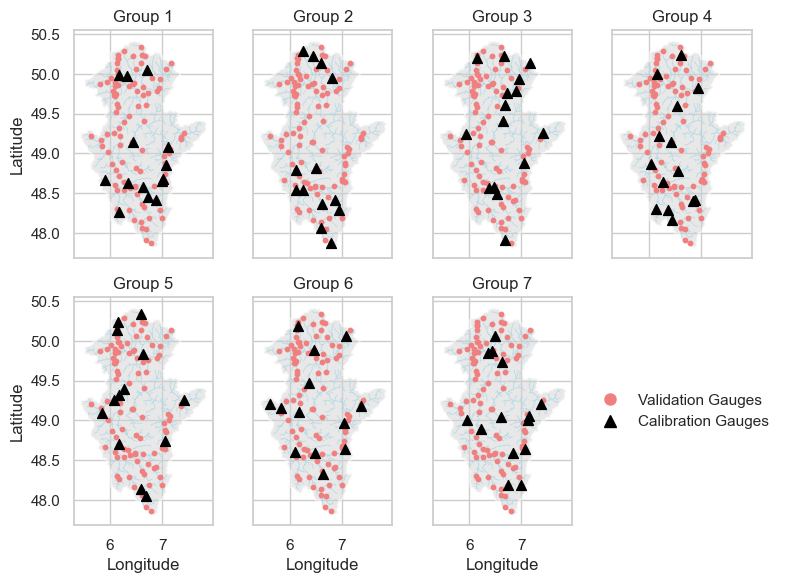

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sns.set_theme(style="whitegrid")

# Prepare data
df = estreams_attributes_filtered.copy()

# Get list of LU basin IDs
lu_ids = df[df.index.str.startswith("LU")].index.tolist()

# Build group_coords excluding LU gauges for calibration
group_coords = [group[["basin_id"]] for group in groups_df.values()]
group_coords = [
    network_estreams.loc[
        [bid for bid in g["basin_id"].tolist() if not bid.startswith("LU")]
    ]
    for g in group_coords
]

# Plot setup
fig, axes = plt.subplots(2, 4, figsize=(8, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(group_coords):
        moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
        rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

        # Show ALL gauges (including LU) in red
        ax.scatter(
            df["lon"], df["lat"],
            color='lightcoral', s=10, label='Validation Gauges', zorder=2
        )

        # Calibration gauges excluding LU
        if not group_coords[i].empty:
            ax.scatter(
                group_coords[i]["lon"],
                group_coords[i]["lat"],
                marker='^',
                color='black',
                s=50,
                zorder=3,
                label=f'Group {i+1}'
            )
        ax.set_title(f"Group {i+1}")

    elif i == 7:
        ax.axis("off")  # Fully empty last subplot
        continue
    else:
        ax.set_title("")

    # X-axis: only show ticks on bottom row
    if i < 4:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Longitude")

    # Y-axis: only show ticks on left column
    if i % 4 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Latitude")

    ax.grid(True)
    # sns.despine(ax=ax)  # Keep full borders if desired

# Add legend to the last (empty) subplot
validation_handle = mlines.Line2D([], [], color='lightcoral', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

axes[7].legend(handles=[validation_handle, calibration_handle], loc='center', frameon=False)
axes[7].axis("off")

plt.tight_layout()

plt.savefig(r"..\results\figs\cal_val_gauges.png", dpi=300)

plt.show()

## Export the groups

In [ ]:
# Export the groups
combined_df.to_csv("../data/network_estreams_moselle_108_gauges.csv")

## End